In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, time
import sys
import matplotlib
from EnKF import EnKF
from SIR import SIR
from OTF import OTF

# Configure matplotlib to embed fonts in PDF/PS outputs and set default font sizes.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font', size=16)

# Set a fixed random seed for reproducibility.
np.random.seed(0)

In [2]:
def L63(x, t):
    """
    Lorenz 63 model function.
    
    Computes the time derivative for a given state vector x at time t according
    to the classic Lorenz 63 chaotic system. Supports both NumPy arrays and 
    PyTorch tensors.
    
    Parameters
    ----------
    x : ndarray or torch.Tensor
        Input state vector.
    t : float
        Time (unused in this formulation, but included for compatibility).
    
    Returns
    -------
    d : ndarray or torch.Tensor
        The computed derivative of x.
    """
    # Prepare an output array/tensor with the same shape as x.
    if isinstance(x, torch.Tensor):
        d = torch.zeros_like(x)
    else:
        d = np.zeros_like(x)
        
    # Set Lorenz 63 model parameters.
    sigma = 10
    r = 28
    b = 8/3

    # Compute the derivative according to the Lorenz equations.
    d[0] = sigma * (x[1] - x[0])
    d[1] = x[0] * (r - x[2]) - x[1]
    d[2] = x[0] * x[1] - b * x[2]
    return x+tau*d

def h(x):
    """
    Observation operator.
    
    Maps the state vector to the observation space by returning the third state
    component in the specified shape.
    
    Parameters
    ----------
    x : ndarray
        Input state vector.
    
    Returns
    -------
    ndarray
        Observation of shape (dy, -1).
    """
    return x[2, :].reshape(dy, -1)

def Gen_True_Data(L, dy, T, sigma0, sigma, gamma, tau):
    """
    Generates true state and observation data using the Lorenz 63 model.
    
    For a given number of time steps, the true state is evolved by integrating 
    the Lorenz 63 model. The observations are generated using an observation rule
    (function h) with added Gaussian noise.
    
    Parameters
    ----------
    L : int
        Dimension of the state space.
    dy : int
        Dimension of the observation space.
    T : int
        Number of time steps.
    sigma0 : float
        Standard deviation for the initial state distribution.
    sigma : float
        Standard deviation for the process noise.
    gamma : float
        Standard deviation for the observation noise.
    tau : float
        Time step size.
    
    Returns
    -------
    x : ndarray
        True state evolution with shape (T x L x 1).
    y : ndarray
        Observations with shape (T x dy x 1).
    """
    # Initialize arrays for state and observation data.
    x = np.zeros((T, L, 1))
    y = np.zeros((T, dy, 1))
    
    # Set initial state with added noise from a multivariate normal distribution.
    x[0,] = np.random.multivariate_normal(np.zeros(L), sigma0 * sigma0 * np.eye(L), 1).T

    # Integrate the Lorenz 63 model through all time steps.
    for i in range(T - 1):
        # Propagate the state using the Lorenz 63 dynamics.
        x[i + 1, :] =  L63(x[i, :], t[i]) 
        # Generate the observation by applying the observation function h and adding noise.
        y[i + 1, :] = h(x[i + 1, :]) + np.random.multivariate_normal(np.zeros(dy), gamma * gamma * np.eye(dy), 1).T
    
    return x, y

In [3]:
# Simulation parameters.
L = 3             # Number of states in the Lorenz system.
tau = 1e-2        # Time step size.
T = int(10 / tau)  # Total number of time steps (simulating for 10 seconds).
t = np.arange(0.0, tau * T, tau)  # Time vector.

dy = 1  # Dimension of the observed state.

# Noise parameters.
sigma = np.sqrt(10) / 10  # Process noise standard deviation.
gamma = np.sqrt(10) * 1   # Observation noise standard deviation.
Noise = [sigma, gamma]

sigma0 = 10  # Standard deviation for the initial state distribution.

N = int(1000 / 4)  # Number of ensemble particles.
NUM_SIM = 1        # Number of independent simulations.

# Define hyperparameters for the optimal transport networks.
parameters = {
    'normalization': 'None',   # Options: 'None', 'Standard', 'MinMax'
    'INPUT_DIM': [L, dy],
    'NUM_NEURON': int(64 / 1),
    'BATCH_SIZE': int(64 / 1),
    'LearningRate': [1e-3 / 5, 1e-3],  # Learning rates for the mapping networks.
    'ITERATION': int(1024 / 1),
    'Final_Number_ITERATION': int(64 / 2),
    'K_in': 10,
    'num_resblocks': [1, 1]  # Number of residual blocks for the two networks.
}

In [4]:
# Containers for true states, observations, and initial particles.
X_True = np.zeros((NUM_SIM, T, L, 1))
Y_True = np.zeros((NUM_SIM, T, dy, 1))
X0 = np.zeros((NUM_SIM, L, N))

# Generate true state trajectories, observations, and initial particles for each simulation.
for k in range(NUM_SIM):
    X_True[k,], Y_True[k,] = Gen_True_Data(L, dy, T, sigma0, sigma, gamma, tau)
    X0[k,] = np.random.multivariate_normal(np.zeros(L), sigma0 * sigma0 * np.eye(L), N).T

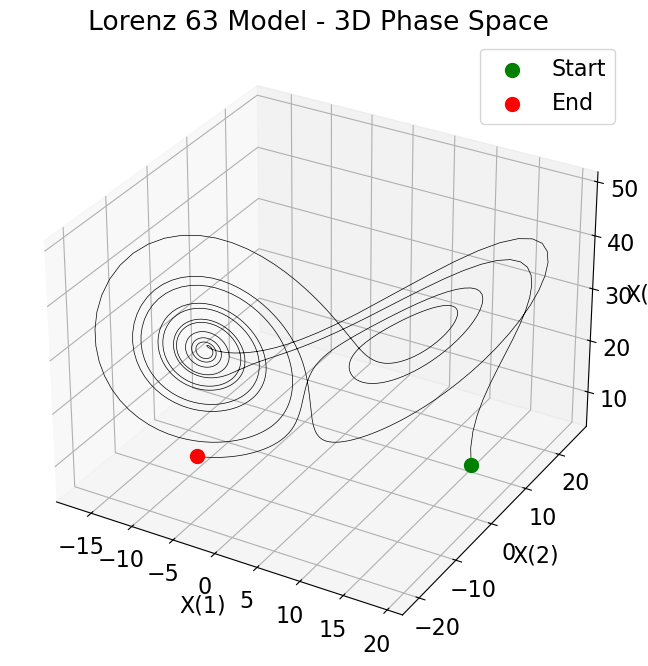

In [5]:
# Plot the Lorenz 63 true state trajectory in 3D phase space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z components from the true state for the first simulation
x_vals = X_True[0, :, 0, 0]
y_vals = X_True[0, :, 1, 0]
z_vals = X_True[0, :, 2, 0]

# Plot the 3D trajectory
ax.plot(x_vals, y_vals, z_vals, 'k-', linewidth=0.5)
ax.scatter(x_vals[0], y_vals[0], z_vals[0], c='g', s=100, label='Start')
ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], c='r', s=100, label='End')

# Set labels and title
ax.set_xlabel('X(1)')
ax.set_ylabel('X(2)')
ax.set_zlabel('X(3)')
ax.set_title('Lorenz 63 Model - 3D Phase Space')
ax.legend()

plt.show()

In [6]:
# Apply filtering methods using the true observations and initial particles.
# The expected data structure is: (NUM_SIM x T x L x N)
X_EnKF = EnKF(Y_True, X0, L63, h, t, Noise, SIGMA=1e-6)
X_SIR = SIR(Y_True, X0, L63, h, t, Noise)
X_OTF = OTF(Y_True, X0, L63, h, t, Noise, parameters)

--- EnKF running time : 0.11915087699890137 seconds ---
--- SIR time : 0.10439562797546387 seconds ---
Simu#1/1, Time Step:1/999, Iteration: 1024/1024, loss = 67.6182
Simu#1/1, Time Step:2/999, Iteration: 1024/1024, loss = 11.4602
Simu#1/1, Time Step:3/999, Iteration: 1024/1024, loss = 2.3274
Simu#1/1, Time Step:4/999, Iteration: 1024/1024, loss = 1.6270
Simu#1/1, Time Step:5/999, Iteration: 1024/1024, loss = 1.7117
Simu#1/1, Time Step:6/999, Iteration: 1024/1024, loss = 2.8374
Simu#1/1, Time Step:7/999, Iteration: 512/512, loss = 1.0670
Simu#1/1, Time Step:8/999, Iteration: 256/256, loss = 1.8404
Simu#1/1, Time Step:9/999, Iteration: 128/128, loss = 2.5620
Simu#1/1, Time Step:10/999, Iteration: 64/64, loss = 2.4294
Simu#1/1, Time Step:11/999, Iteration: 32/32, loss = 2.5159
Simu#1/1, Time Step:12/999, Iteration: 32/32, loss = 2.6426
Simu#1/1, Time Step:13/999, Iteration: 32/32, loss = 4.0927
Simu#1/1, Time Step:14/999, Iteration: 32/32, loss = 4.6297
Simu#1/1, Time Step:15/999, Iterat

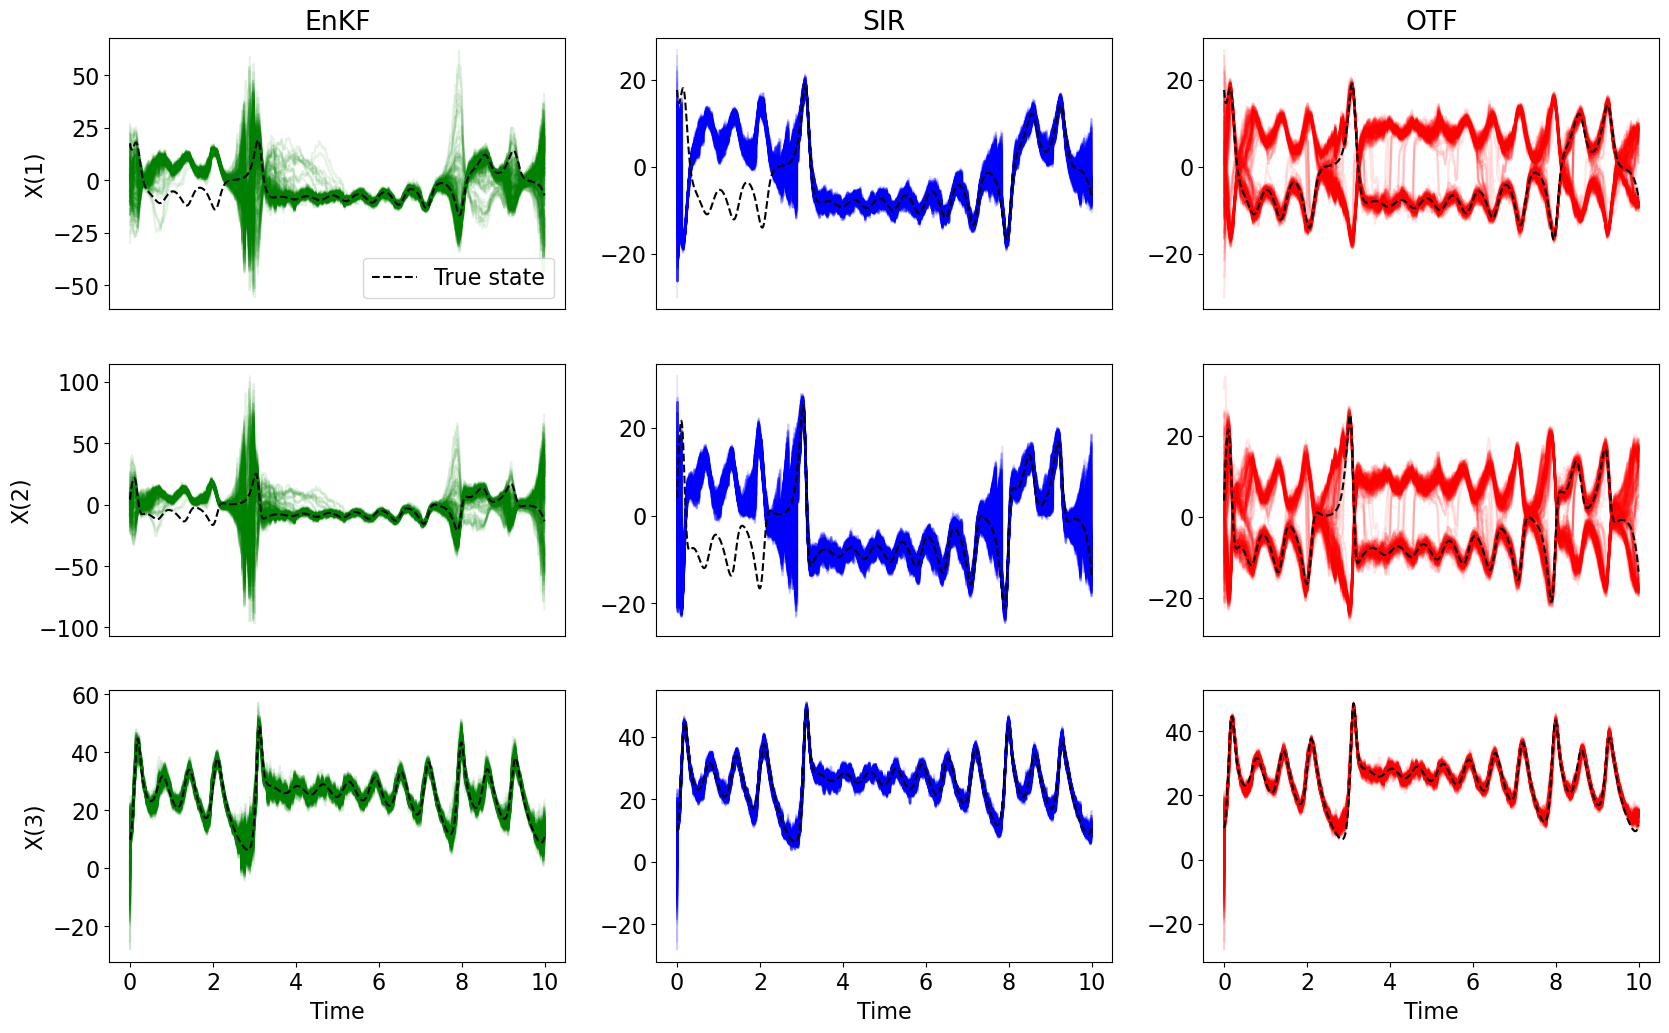

In [7]:
# Plot the results for each filtering method alongside the true state.
plt.figure(figsize=(20, 12))
for l in range(L):
    # Plot EnKF results.
    plt.subplot(L, 3, 3 * l + 1)
    plt.plot(t, X_EnKF[k, :, l, :], 'g', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('EnKF')
        plt.legend()
    plt.ylabel(f'X({l + 1})')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

for l in range(L):
    # Plot SIR results.
    plt.subplot(L, 3, 3 * l + 2)
    plt.plot(t, X_SIR[k, :, l, :], 'b', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('SIR')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

for l in range(L):
    # Plot OTF results.
    plt.subplot(L, 3, 3 * l + 3)
    plt.plot(t, X_OTF[k, :, l, :], 'r', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('OTF')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

# Optionally, you can display the plots by calling plt.show() here.
plt.show()